In [1]:
# Aminov Rezo
import numpy as np
import wave
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob
import random

import struct

from keras.models import *
from keras.layers import *
from keras.callbacks import *

import librosa
import soundfile as sf

/home/aminov/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
DATA_DIR = 'data_v_7_stc'

1 2 22050 46614
[ 989  296 -512  191  509 -153  140  557 -198 -306  429   73 -493  227
  810  166 -463 -182  284   -9]


/home/aminov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.


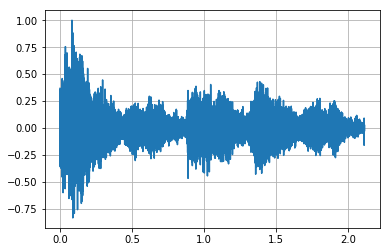

1 2 22050 78774
[-1 -2  0  0 -2 -1  0 -1  0  0 -1  0 -2 -1  1  0 -1  1  1  3]


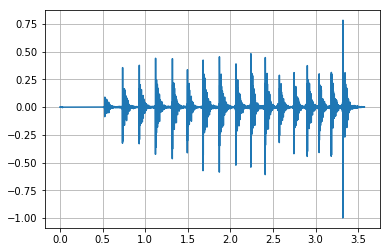

1 2 16000 126696
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0]


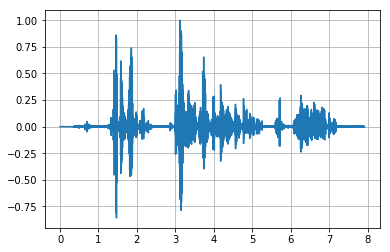

In [3]:
def loadwav(file):
    test_file = DATA_DIR+"/audio/"+file+".wav"

    with wave.open(test_file, 'rb') as f:
        params = f.getparams()
        nchannels, sampwidth, framerate, nframes = params[:4]
        print(nchannels, sampwidth, framerate, nframes) 
        strData = f.readframes(nframes)

    waveData = np.fromstring(strData, dtype=np.int16)

    print(waveData[:20])

    waveData_norm = waveData * 1.0 / (max(abs(waveData)))

    time = np.arange(0, nframes)*(1.0 / framerate)
    return time, waveData_norm
    
time, waveData_norm = loadwav('bg_0048_time_stretch_0')
plt.plot(time, waveData_norm)
plt.grid('on')
plt.show()

time1, waveData_norm1 = loadwav('knocking_door_0037_time_stretch_5')
plt.plot(time1, waveData_norm1)
plt.grid('on')
plt.show()

time1, waveData_norm1 = loadwav('speech_0038')
plt.plot(time1, waveData_norm1)
plt.grid('on')
plt.show()

## Load DF

In [4]:
meta_file = "{}/meta/meta.txt".format(DATA_DIR)

In [5]:
df = pd.read_csv(meta_file, sep='\t',header=None)

In [6]:
len(df)

11307

In [7]:
df.head()

,0,1,2,3,4
0,background_0001.wav,office,0,9.458500,background
1,background_0001_time_stretch_0.wav,office,0,9.989070,background
2,background_0001_time_stretch_1.wav,office,0,9.879410,background
3,background_0001_time_stretch_10.wav,office,0,11.156553,background
4,background_0001_time_stretch_11.wav,office,0,13.261587,background


In [8]:
# mean time
df[3].mean()

5.351487826656803

In [9]:
# все уникальные лейблы
labels_name = df[4].unique()

In [10]:
for lbl in labels_name:    
    print(lbl, df[df[4] == lbl][3].mean())

background 5.700111284300551
bags 5.865723850435567
door 1.8829364572380813
keyboard 6.443274706256089
knocking_door 3.4744397525113375
ring 13.413474140953678
speech 35.94874999999998
tool 4.386049502712482


In [11]:
# кодирование лейблов
onehot_dict = {}
for ii, lab in enumerate(labels_name):
    y_ = np.zeros(len(labels_name))
    y_[ii] = 1
    onehot_dict.update({lab:ii})

In [13]:
# экстрактор фич: Мел-кепстральные коэффициенты (MFCC). https://habr.com/post/140828/
def extract_feature(file_name):
    X, sample_rate = sf.read(file_name, dtype='float32')
    if X.ndim > 1:
        X = X[:,0]
    X = X.T
    # преобразование Фурье
    stft = np.abs(librosa.stft(X))
    # MFCC
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=128).T,axis=0)
    # chroma
#     chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    # мэл спектр
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    # спектр-ный контраст
#     contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

#     tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    return mfccs,mel

In [ ]:
cnt=0
features, labels = np.empty((0,256)), np.empty(0)
for file, label in zip(df[0],df[4]):
    try:
        cnt+=1
        mfccs, mel = extract_feature(DATA_DIR+'/audio/'+file)
    except Exception as e:
        print("[Error] extract feature error. %s" % (e))
        continue
    ext_features = np.hstack([mfccs,mel])
    features = np.vstack([features,ext_features])
    labels = np.append(labels, onehot_dict[label])
    print(cnt)


In [160]:
features = np.array(features)
labels = np.array(labels)

In [13]:
np.save('feat.npy', features)
np.save('label.npy', labels)

In [162]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split

In [163]:
# Prepare the data
# X = np.load('feat.npy')
# y = np.load('label.npy').ravel()

X = features
y = labels

# X = np.exp(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=233)


In [164]:
# 3 конв. слоя, 2 полносвяз. слоя

model = Sequential()

model.add(Conv1D(128, 3, activation='relu', input_shape=(256, 1)))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(128, 7, activation='relu'))
model.add(Conv1D(128, 9, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(8, activation='softmax'))


# model.add(Conv1D(64, 3, activation='relu', input_shape=(256, 1)))
# model.add(Conv1D(64, 3, activation='relu'))
# model.add(MaxPooling1D(3))
# model.add(Conv1D(128, 3, activation='relu'))
# model.add(Conv1D(128, 3, activation='relu'))
# model.add(GlobalAveragePooling1D())
# model.add(Dropout(0.5))
# model.add(Dense(8, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])#adam

In [165]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_52 (Conv1D)           (None, 254, 128)          512       
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 250, 128)          82048     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 83, 128)           0         
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 77, 128)           114816    
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 69, 128)           147584    
_________________________________________________________________
global_average_pooling1d_16  (None, 128)               0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
__________

In [166]:
y_train = keras.utils.to_categorical(y_train , num_classes=8)
y_test = keras.utils.to_categorical(y_test , num_classes=8)

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

In [169]:
res = model.fit(X_train, y_train, batch_size=64,validation_data=(X_test, y_test), epochs=5)


Train on 7914 samples, validate on 3393 samples
Epoch 1/5
7914/7914 [==============================] - 2s 195us/step - loss: 0.0419 - acc: 0.9937 - val_loss: 0.0678 - val_acc: 0.9912
Epoch 2/5
7914/7914 [==============================] - 2s 192us/step - loss: 0.0416 - acc: 0.9928 - val_loss: 0.0550 - val_acc: 0.9912
Epoch 3/5
7914/7914 [==============================] - 2s 195us/step - loss: 0.0344 - acc: 0.9944 - val_loss: 0.0530 - val_acc: 0.9915
Epoch 4/5
7914/7914 [==============================] - 2s 195us/step - loss: 0.0254 - acc: 0.9963 - val_loss: 0.0882 - val_acc: 0.9856
Epoch 5/5
7914/7914 [==============================] - 2s 194us/step - loss: 0.0402 - acc: 0.9922 - val_loss: 0.0583 - val_acc: 0.9906


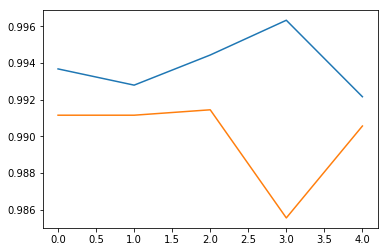

In [170]:
# accuracy
plt.plot(res.history['acc'])
plt.plot(res.history['val_acc'])

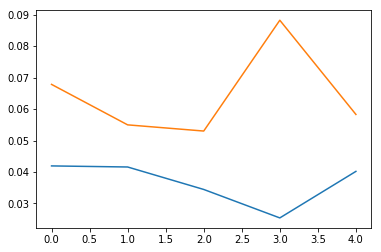

In [171]:
# loss
plt.plot(res.history['loss'])
plt.plot(res.history['val_loss'])

In [172]:
# оценка модели на тестовых данных
score, acc = model.evaluate(X_test, y_test, batch_size=16)

3393/3393 [==============================] - 1s 212us/step


In [173]:
score, acc

(0.058287774928335714, 0.9905688181550251)

In [179]:
model.save('weights/model.hdf5')
model.save_weights('weights/model_weights.hdf5')

## -------------------------------------------------------------------------------------------

In [174]:
files_test = glob(DATA_DIR+'/test/*.wav')

# обратный хэш
hot_to_one = {}
for k,v in onehot_dict.items():
    hot_to_one.update({v:k})

In [175]:
CNT=0 # кол-во всех не 'unknown', подмножество 'A'
GOOD=0 # кол-во правильно опред-ых файлов в подмножестве 'A'
BAD=0 # кол-во не правильно опред-ых файлов в подмножестве 'A'

filew = open("result.txt","a") 
features_test = np.empty((0,256))
for file in files_test:    
    try:
        mfccs,mel = extract_feature(file)
    except Exception as e:
        print("[Error] extract feature error. %s" % (e))
        continue
    ext_features_test = np.hstack([mfccs,mel])
#     features_test = np.vstack([features_test,ext_features_test])
    pred = model.predict(np.expand_dims([ext_features_test],axis=2))
    score = pred.max()
    class_ = hot_to_one[np.argmax(pred)]
    filename = file.split('/')[2]
    
    filew.write(filename+'\t'+str(score)+'\t'+class_+'\n')
    print(filename+' '+str(score)+' '+class_)
    
    # если файл не 'unknown', делаю подсчет совпадений лейбла и наз. файла
    # примерный подсчет, т.к. неизвестно к какому классу относятся файлы
    # с наз. 'unknown'
    if 'unknown' not in filename:
        CNT+=1
        if class_ in filename:
            GOOD+=1
        else:
            BAD+=1
    
filew.close()

unknown_0070.wav 0.9344851 speech
bags_t_0019.wav 0.998005 bags
door_0085.wav 1.0 door
background_0060.wav 0.99999845 background
background_0036.wav 0.7489906 keyboard
speech_0086.wav 0.7623892 door
bags_0038.wav 1.0 bags
speech_0074.wav 1.0 speech
unknown_0034.wav 0.9984611 bags
speech_t_0031.wav 1.0 speech
knocking_door_0066.wav 1.0 knocking_door
knocking_door_t_0003.wav 1.0 knocking_door
knocking_door_0060.wav 1.0 knocking_door
bags_0086.wav 1.0 bags
unknown_0033.wav 0.9978265 door
knocking_door_t_0007.wav 0.9996518 knocking_door
background_t_0011.wav 0.9677452 background
keyboard_t_0001.wav 0.79298896 keyboard
bags_t_0023.wav 0.9998534 bags
unknown_0071.wav 0.99996805 tool
unknown_0089.wav 1.0 keyboard
keyboard_0026.wav 1.0 keyboard
speech_0008.wav 0.9999994 speech
speech_0006.wav 0.9982772 speech
unknown_0115.wav 0.81491566 tool
background_0022.wav 0.9863581 background
knocking_door_0018.wav 0.9040094 knocking_door
speech_0071.wav 0.89825416 speech
tool_0004.wav 1.0 tool
speech_00

ring_0002.wav 0.99999976 ring
unknown_0137.wav 0.9987184 tool
background_0063.wav 0.99987674 background
keyboard_0046.wav 0.9999995 keyboard
unknown_0102.wav 0.933946 keyboard
bags_t_0012.wav 1.0 bags
unknown_0075.wav 0.9991726 keyboard
background_t_0001.wav 0.99477214 background
bags_0082.wav 1.0 bags
background_t_0013.wav 0.992268 background
keyboard_0008.wav 1.0 keyboard
unknown_0087.wav 0.99995136 background
knocking_door_t_0017.wav 0.99998534 door
ring_0048.wav 0.99857473 ring
door_t_0017.wav 0.9912019 door
speech_0031.wav 1.0 speech
speech_0083.wav 1.0 speech
ring_0022.wav 1.0 ring
door_0061.wav 0.99897003 background
knocking_door_0057.wav 1.0 knocking_door
unknown_0004.wav 0.9986553 tool
unknown_0118.wav 0.9990963 speech
ring_0003.wav 0.99995804 ring
speech_0087.wav 1.0 speech
speech_0085.wav 1.0 speech
unknown_0016.wav 0.84015656 keyboard
speech_0015.wav 0.9971559 speech
ring_0015.wav 1.0 ring
door_0005.wav 0.9999664 door
keyboard_0068.wav 0.9993266 keyboard
unknown_0076.wav 1.

unknown_0120.wav 0.9992741 tool
speech_t_0037.wav 1.0 speech
bags_0017.wav 1.0 bags
unknown_0060.wav 0.99997604 tool
unknown_0017.wav 0.99933004 tool
door_t_0020.wav 0.8936496 door
tool_0007.wav 0.9999999 tool
unknown_0062.wav 0.9999678 tool
ring_0020.wav 1.0 ring
background_0012.wav 0.9999598 background
ring_t_0004.wav 1.0 ring
unknown_0111.wav 0.9703059 keyboard
unknown_0100.wav 0.99996555 keyboard
unknown_0064.wav 1.0 tool
unknown_0023.wav 0.58126664 tool
door_t_0008.wav 1.0 door
background_0051.wav 0.9989172 background
keyboard_0012.wav 1.0 keyboard
background_t_0005.wav 0.9999821 background
knocking_door_0014.wav 1.0 knocking_door
background_0046.wav 0.99931073 background
speech_0037.wav 1.0 speech
keyboard_t_0022.wav 0.56137395 keyboard
speech_0070.wav 1.0 speech
tool_0011.wav 1.0 ring
keyboard_t_0013.wav 0.75214785 keyboard
bags_0032.wav 0.99873024 bags
speech_0042.wav 0.9999527 speech
ring_t_0009.wav 1.0 ring
keyboard_t_0003.wav 0.500391 speech
knocking_door_0001.wav 1.0 knocki

In [176]:
CNT, GOOD, BAD

(473, 431, 42)

In [177]:
GOOD/CNT

0.9112050739957717